<a href="https://colab.research.google.com/github/franitaa/ADHD-EEG-Game/blob/main/ADHD_EEG_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de ADHD

*   Francesca Rondinella (61031)
*   Nicolás Suárez Durrels (62468)


## Dudas

- Para sujetos non-ADHD, hay data de los canales de EEG y data ya dividida en bandas de frecuencia. Para los sujetos ADHD sólo está la data de las bandas, y por eso nos quedamos solo con esa información en ambos casos para el análisis. Está ok como approach?
- Agregamos las columnas que usan en el paper? Nos da dudas, porque son ratios entre las distintas bandas de frecuencia (literalmente, theta/gamma y así). No sabemos si no sería como repetir los datos.
- 125 Hz rate de sampleo, lo calculamos con los timestamps que están en los datos de no-ADHD. Es correcto pensar que para las bandas de frecuencia, como usan ventanas de tamaño 5 sin overlap, la fs = 125 / 5 = 25 Hz?.

## TODO

*   Fran: graficar señales en el tiempo y ver qué onda
*   Nico: PCA al espectrograma o LDA, t-SNE, SVM



## Imports y carga de datos

In [8]:
#Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from google.colab import drive
import os
import numpy as np
import seaborn as sns
from scipy.signal import spectrogram

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# TODO CHECK hay muchos archivos de non adhd que no se que son

main_folder_path = '/content/drive/MyDrive/New EEG Data'

# dictionaries
adhd_emotive = {}
adhd_keyboard = {}
non_adhd_emotive = {}
non_adhd_keyboard = {}

def read_and_categorize_csv_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                # categoria segun path
                relative_path = os.path.relpath(file_path, main_folder_path)
                parts = relative_path.split(os.sep)

                if len(parts) >= 3:
                    category = parts[0]  # ADHD o Non-ADHD
                    subcategory = parts[2]  # Emotive o Keyboard

                    #df = pd.read_csv(file_path)
                    df = pd.read_csv(file_path, index_col=False).dropna(how='all')

                    #selected_columns = ['Theta', ' Alpha', ' Low_beta', ' High_beta', ' Gamma ']
                    #filtered_df  = df[selected_columns]
                    # Strip leading/trailing spaces from column names
                    df.columns = df.columns.str.strip()
                    #print("Available columns:", df.columns.tolist())
                    #print(parts)

                    selected_columns = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']

                    if all(column in df.columns for column in selected_columns):
                      filtered_df  = df[selected_columns]
                      if category == 'ADHD' and subcategory == 'Emotiv':
                          adhd_emotive[relative_path] = df
                      elif category == 'ADHD' and subcategory == 'Keyboard':
                          adhd_keyboard[relative_path] = df
                      elif category == 'Non-ADHD' and subcategory == 'Emotive':
                          non_adhd_emotive[relative_path] = df
                      elif category == 'Non-ADHD' and subcategory == 'Keyboard':
                          non_adhd_keyboard[relative_path] = df



read_and_categorize_csv_files(main_folder_path)

print("ADHD - Emotive:", adhd_emotive.keys())
print("ADHD - Keyboard:", adhd_keyboard.keys())
print("Non-ADHD - Emotive:", non_adhd_emotive.keys())
print("Non-ADHD - Keyboard:", non_adhd_keyboard.keys())


ADHD - Emotive: dict_keys(['ADHD/7/Emotiv/ayse nur emo 1.csv', 'ADHD/7/Emotiv/ayse nur emo 2.csv', 'ADHD/7/Emotiv/ayse nur emo 3.csv', 'ADHD/7/Emotiv/ayse nur emo 4.csv', 'ADHD/7/Emotiv/ayse nur emo 5.csv', 'ADHD/7/Emotiv/ayse nur emo 6.csv', 'ADHD/10/Emotiv/emo zeynep 1.csv', 'ADHD/10/Emotiv/emo zeynep 2.csv', 'ADHD/10/Emotiv/emo zeynep 3.csv', 'ADHD/10/Emotiv/emo zeynep 4.csv', 'ADHD/10/Emotiv/emo zeynep 5.csv', 'ADHD/10/Emotiv/emo zeynep 6.csv', 'ADHD/8/Emotiv/Humam emo 1.csv', 'ADHD/8/Emotiv/Humam emo 2.csv', 'ADHD/8/Emotiv/Humam emo 3.csv', 'ADHD/8/Emotiv/Humam emo 4.csv', 'ADHD/8/Emotiv/Humam emo 5.csv', 'ADHD/8/Emotiv/Humam emo 6.csv', 'ADHD/9/Emotiv/emo said 1.csv', 'ADHD/9/Emotiv/emo said 2.csv', 'ADHD/9/Emotiv/emo said 3.csv', 'ADHD/9/Emotiv/emo said 4.csv', 'ADHD/9/Emotiv/emo said 5.csv', 'ADHD/9/Emotiv/emo said 6.csv'])
ADHD - Keyboard: dict_keys(['ADHD/7/Keyboard/ayse nur key 1.csv', 'ADHD/7/Keyboard/ayse nur key 2.csv', 'ADHD/7/Keyboard/ayse nur key 3.csv', 'ADHD/7/Keyboa

In [4]:
print(non_adhd_emotive['Non-ADHD/2/Emotive/alaa_emo1.csv'].keys)

<bound method NDFrame.keys of          Theta     Alpha  Low_beta  High_beta     Gamma
0     1.240181  0.900676  0.409132   0.431120  0.082212
1     0.398977  0.348877  0.132882   0.096119  0.079564
2     0.728530  0.687372  0.148767   0.161910  0.234107
3     3.042919  0.753375  0.542238   0.557061  0.284002
4     1.046734  0.853509  0.409447   0.401535  0.109164
...        ...       ...       ...        ...       ...
3735  4.077168  0.359713  0.971347   0.492080  0.140560
3736  8.874057  1.564990  1.426825   1.073386  0.477012
3737  1.536944  0.245191  0.320641   0.314630  0.240329
3738  2.515144  1.364814  0.950630   0.750367  0.422408
3739  5.025025  0.391393  0.701822   0.373607  0.127021

[3740 rows x 5 columns]>


In [ ]:

#for column_name, column_data in adhd_emotive['ADHD/10/Emotiv/emo zeynep 2.csv'].items():
    #print("hola")
    #print(f"Columna: {column_name}")
    #print(column_data)





In [6]:
# Combine all DataFrames in a dictionary
def combine_data(data_dict):
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    return combined_df


combined_adhd_emotive = combine_data(adhd_emotive)
combined_adhd_keyboard = combine_data(adhd_keyboard)
combined_non_adhd_emotive = combine_data(non_adhd_emotive)
combined_non_adhd_keyboard = combine_data(non_adhd_keyboard)


combined_adhd_emotive['Label'] = 'ADHD_emotive'
combined_adhd_keyboard['Label'] = 'ADHD_keyboard'
combined_non_adhd_emotive['Label'] = 'Non_ADHD_emotive'
combined_non_adhd_keyboard['Label'] = 'Non_ADHD_keyboard'

# Combine all DataFrames and add labels
#combined_data = pd.concat([combined_adhd_emotive, combined_adhd_keyboard,
#                           combined_non_adhd_emotive, combined_non_adhd_keyboard])

# Deberiamos usar los 4 creo, pero con esto se ve la mayor "diferencia"
# Igual pca creo q es medio pelo para esto pero queria ver algo de los datos
combined_data = pd.concat([combined_adhd_emotive,
                           combined_non_adhd_emotive])

features = ['Theta', 'Alpha', 'Low_beta', 'High_beta', 'Gamma']
x = combined_data[features]
y = combined_data['Label']

# TODO check this, estoy sacando outliers
z_scores = np.abs((x - x.mean()) / x.std())
x = x[(z_scores < 3).all(axis=1)]
y = y[(z_scores < 3).all(axis=1)]
# Standardize the features
x = StandardScaler().fit_transform(x)

## Análisis preliminar de los datos

Principal components (eigenvectors):
[[ 0.43269624  0.46423371  0.47454453  0.47295762  0.38520073]
 [ 0.47625895  0.36964866  0.09560642 -0.29614728 -0.73463833]]

Explained variance ratio:
[0.75636126 0.13843159]


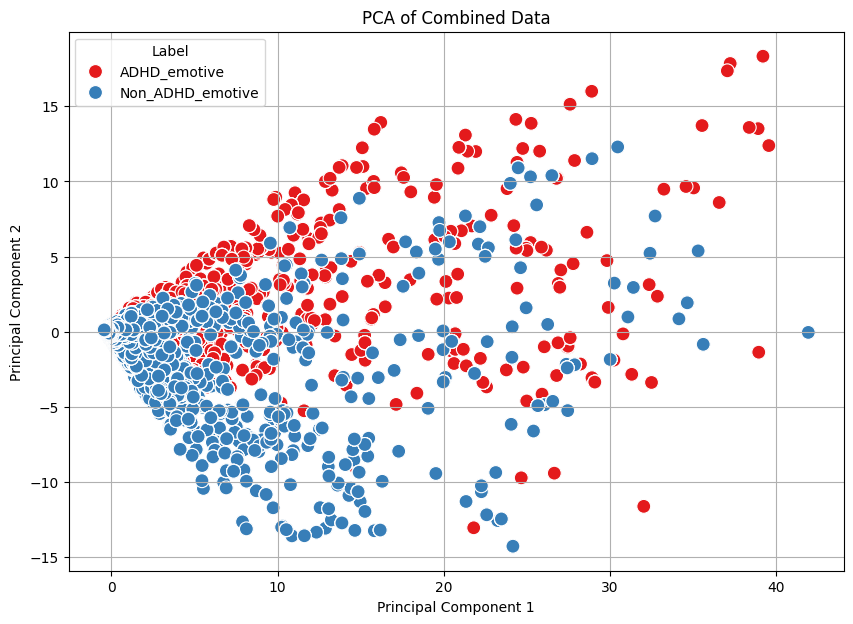

In [7]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

# Combine the principal components with the labels
final_df = pd.concat([principal_df, y.reset_index(drop=True)], axis=1)

print("Principal components (eigenvectors):")
print(pca.components_)

print("\nExplained variance ratio:")
print(pca.explained_variance_ratio_)

# Plot the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=final_df, x='principal_component_1', y='principal_component_2', hue='Label', palette='Set1', s=100)
plt.title('PCA of Combined Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label', loc='best')
plt.grid(True)
plt.show()

In [10]:
values = non_adhd_emotive['Non-ADHD/2/Emotive/alaa_emo1.csv']

In [14]:
values2 = adhd_emotive['ADHD/10/Emotiv/emo zeynep 5.csv']

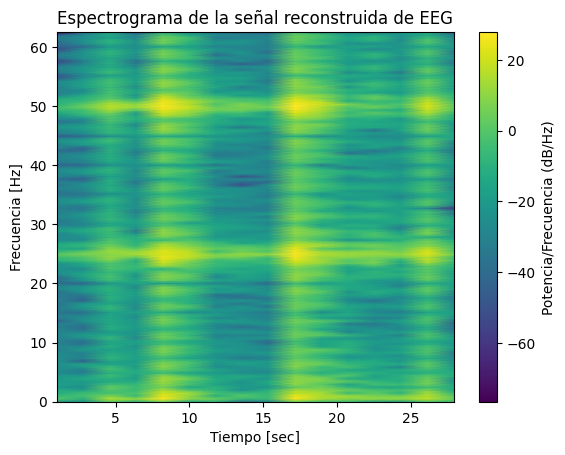

In [20]:
full_signal1 = values['Alpha'] + values['Theta'] + values['High_beta'] + values['Low_beta'] + values['Gamma']

fs = 125

f, t, Sxx = spectrogram(full_signal1, fs)

plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [sec]')
plt.title('Espectrograma de la señal reconstruida de EEG')
plt.colorbar(label='Potencia/Frecuencia (dB/Hz)')
plt.show()

Comentarios: se nota la banda característica de ruido de línea en todo el espectro a 50 Hz, que pareciera estar filtrada por el color (baja potencia). Sin embargo, tiene otras líneas que no sé a que atribuir (alrededor de 25 Hz y las otras verticales). Podría deberse a gaps según como hayan tomado las bandas frecuenciales.

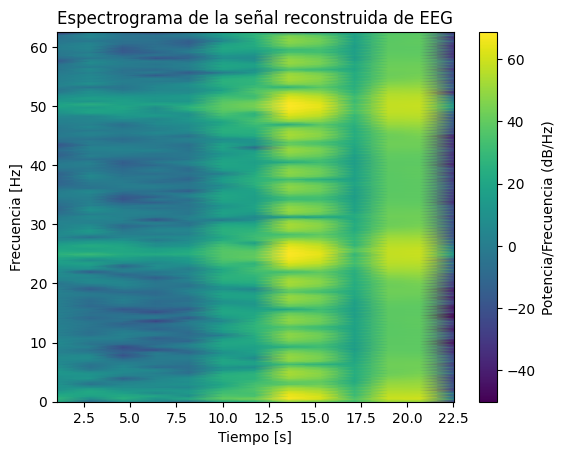

In [21]:
full_signal2 = values2['Alpha'] + values2['Theta'] + values2['High_beta'] + values2['Low_beta'] + values2['Gamma']

fs = 125

f, t, Sxx = spectrogram(full_signal2, fs)

plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma de la señal reconstruida de EEG')
plt.colorbar(label='Potencia/Frecuencia (dB/Hz)')
plt.show()

Punto positivo: se ven distintos. Tiene sentido hacer espectrogramas así y después hacer PCA o LDA a ver que sale?

Citando el comentario de Facu: "Imagino que un PCA aplicado a los espectrogramas de las señales podría llegar a darles información acerca de la composición". La idea sería ver que bandas de frecuencia explican la mayor varianza? No entendemos bien como se aplica PCA al espectrograma.

Otras features que podemos usar, que son usuales en análisis de EEG, son: dimensión fractal, ICA, FFT, Wavelet Transform.

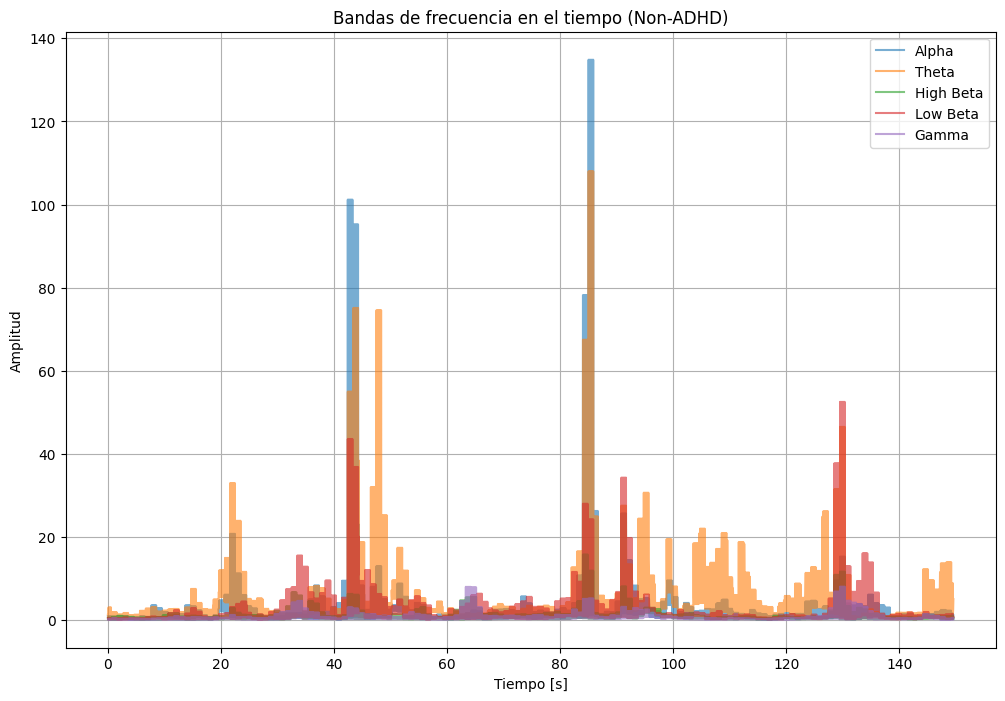

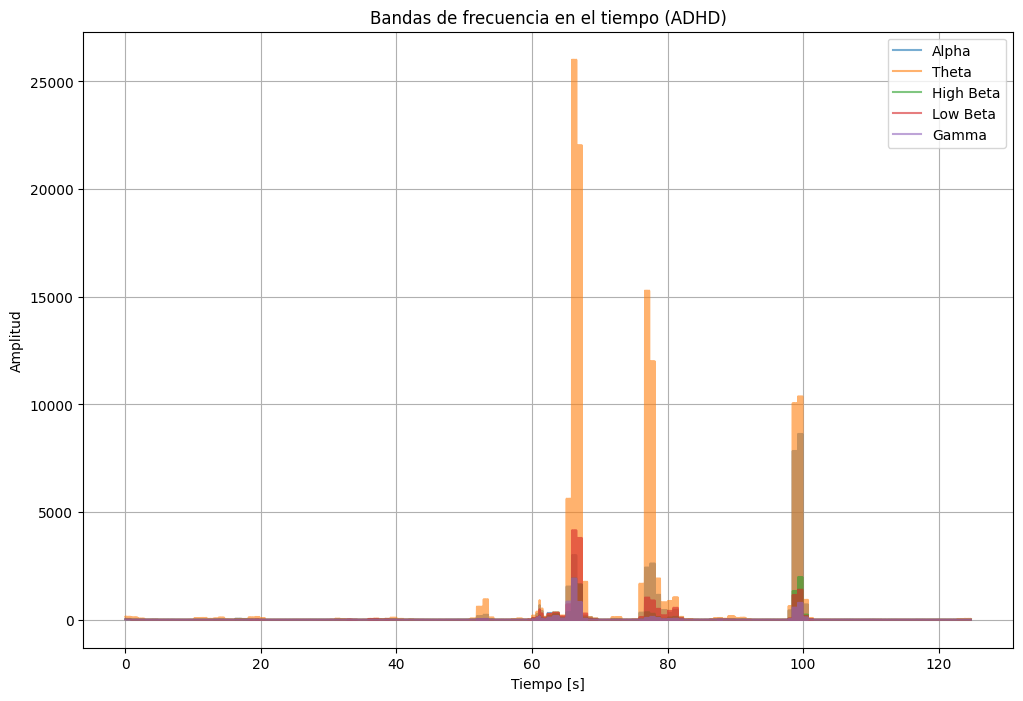

In [24]:
# @title Ploteo
alpha = values['Alpha']
theta = values['Theta']
high_beta = values['High_beta']
low_beta = values['Low_beta']
gamma = values['Gamma']


fs = 125/5  # no sé si esto está bien, es fs/window size
t = values.index / fs

plt.figure(figsize=(12, 8))

plt.plot(t, alpha, label='Alpha', alpha=0.6)
plt.plot(t, theta, label='Theta', alpha=0.6)
plt.plot(t, high_beta, label='High Beta', alpha=0.6)
plt.plot(t, low_beta, label='Low Beta', alpha=0.6)
plt.plot(t, gamma, label='Gamma', alpha=0.6)

# plt.plot(t, full_signal, label='Full Signal', linestyle='--', color='black', alpha=0.7)

plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (Non-ADHD)')
plt.legend()
plt.grid(True)

plt.show()

alpha2 = values2['Alpha']
theta2 = values2['Theta']
high_beta2 = values2['High_beta']
low_beta2 = values2['Low_beta']
gamma2 = values2['Gamma']

t = values2.index / fs


plt.figure(figsize=(12, 8))

plt.plot(t, alpha2, label='Alpha', alpha=0.6)
plt.plot(t, theta2, label='Theta', alpha=0.6)
plt.plot(t, high_beta2, label='High Beta', alpha=0.6)
plt.plot(t, low_beta2, label='Low Beta', alpha=0.6)
plt.plot(t, gamma2, label='Gamma', alpha=0.6)

# plt.plot(t, full_signal, label='Full Signal', linestyle='--', color='black', alpha=0.7)

plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Bandas de frecuencia en el tiempo (ADHD)')
plt.legend()
plt.grid(True)

plt.show()


# plt.figure(figsize=(12, 8))

# plt.plot(t, full_signal1, label='Full Signal Non-ADHD', color='lightgreen', alpha=0.7)
# plt.plot(t, full_signal2, label='Full Signal ADHD', color='mediumpurple', alpha=0.7)


# plt.xlabel('Tiempo [s]')
# plt.ylabel('Amplitud')
# plt.title('Bandas de frecuencia en el tiempo comparadas')
# plt.legend()
# plt.grid(True)

# plt.show()